# GoogLeNet Implementation on Fashion MNIST dataset
# With minor modification made: setting the dropout rate to 0.5
## Author: Tom Tabak (Student ID:160889015)

In [0]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.datasets import fashion_mnist
import keras
import cv2

(x_train, y_train), (x_test, y_test) =fashion_mnist.load_data()

x_train=x_train.astype('uint8')
x_test=x_test.astype('uint8')

no_classes = len(list(set(y_train)))

y_train, y_test=keras.utils.to_categorical(y_train, no_classes), keras.utils.to_categorical(y_test, no_classes)
print(np.shape(x_train))
X_train = []
for i in range(np.shape(x_train)[0]):
    res = cv2.resize(x_train[i], (224, 224))
    X_train.append(res)
X_train=np.array(X_train)
X_train = np.reshape(X_train, [np.shape(X_train)[0], 224,224,1])
print(np.shape(X_train))

IMAGE_SHAPE = (224, 224, 1)



# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3, 3), strides=1, padding='same', activation='relu')(path2)

    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5, 5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1, path2, path3, path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5, 5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units=no_classes, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)

    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [64, (96, 128), (16, 32), 32])  # 3a
    layer = inception(layer, [128, (128, 192), (32, 96), 64])  # 3b
    layer = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    # stage-4
    layer = inception(layer, [192, (96, 208), (16, 48), 64])  # 4a
    aux1 = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112, 224), (24, 64), 64])  # 4b
    layer = inception(layer, [128, (128, 256), (24, 64), 64])  # 4c
    layer = inception(layer, [112, (144, 288), (32, 64), 64])  # 4d
    aux2 = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160, 320), (32, 128), 128])  # 4e
    layer = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    # stage-5
    layer = inception(layer, [256, (160, 320), (32, 128), 128])  # 5a
    layer = inception(layer, [384, (192, 384), (48, 128), 128])  # 5b
    layer = AveragePooling2D(pool_size=(7, 7), strides=1, padding='valid')(layer)

    # stage-8
    layer = Flatten()(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=no_classes, activation='softmax', name='main')(layer)
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

GoogLeNet = googlenet()

google_hist = GoogLeNet.fit(X_train, [y_train, y_train, y_train], epochs=10, validation_split=0.2, verbose=2, batch_size=32)


Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 224, 224, 1)
Epoch 1/10
1500/1500 - 119s - loss: 1.7262 - main_loss: 0.6461 - aux1_loss: 0.5253 - aux2_loss: 0.5548 - main_accuracy: 0.7595 - aux1_accuracy: 0.8093 - aux2_accuracy: 0.7978 - val_loss: 1.0519 - val_main_loss: 0.3769 - val_aux1_loss: 0.3358 - val_aux2_loss: 0.3391 - val_main_accuracy: 0.8668 - val_aux1_accuracy: 0.8760 - val_aux2_accuracy: 0.8755
Epoch 2/10
1500/1500 - 118s - loss: 1.0087 - main_loss: 0.3507 - aux1_loss: 0.3276 - aux2_loss: 0.3304 - main_accuracy: 0.8753 - aux1_accuracy: 0.8806 - aux2_accuracy: 0.8792 - val_loss: 0.8599 - val_main_loss: 0.2935 - val_aux1_loss: 0.2864 - val_aux2_loss: 0.2800 - val_main_accuracy: 0.8891 - val_aux1_accuracy: 0.8932 - val_aux2_accuracy: 0.8971
Epoch 3/10
1500/1500 - 118s - loss: 0.8448 - main_loss: 0.2930 - aux1_loss: 0.2766 - aux2_loss: 0.2752 - main_accuracy: 0.8947 - aux1_accuracy: 0.8986 - aux2_accuracy: 0.9002 - val_loss: 0.7696 - val_

In [0]:
X_test = []
for i in range(np.shape(x_test)[0]):
    res = cv2.resize(x_test[i], (224, 224))
    X_test.append(res)
X_test=np.array(X_test)
X_test = np.reshape(X_test, [np.shape(X_test)[0], 224,224,1])
print('Accuracy: {}'.format(GoogLeNet.evaluate(X_test, y_test, batch_size=32)[5]))

313/313 [==============================] - 9s 29ms/step - loss: 0.7952 - main_loss: 0.2797 - aux1_loss: 0.2592 - aux2_loss: 0.2563 - main_accuracy: 0.8934 - aux1_accuracy: 0.9084 - aux2_accuracy: 0.9057
Accuracy: 0.9083999991416931


{'loss': [1.7261954545974731, 1.008707880973816, 0.844784677028656, 0.7349376082420349, 0.680219292640686, 0.6269859671592712, 0.5941457748413086, 0.5578397512435913, 0.5198912024497986, 0.4957272410392761], 'main_loss': [0.6461084485054016, 0.35066649317741394, 0.29298192262649536, 0.2558140754699707, 0.23443391919136047, 0.21702972054481506, 0.2054899036884308, 0.19224755465984344, 0.18151035904884338, 0.17232085764408112], 'aux1_loss': [0.5253192782402039, 0.32764187455177307, 0.2765943706035614, 0.23932670056819916, 0.22494851052761078, 0.20434699952602386, 0.19456171989440918, 0.18404893577098846, 0.17028389871120453, 0.16119137406349182], 'aux2_loss': [0.5547682642936707, 0.330399751663208, 0.27520909905433655, 0.23979617655277252, 0.22083742916584015, 0.20560923218727112, 0.19409406185150146, 0.18154321610927582, 0.1680966317653656, 0.16221530735492706], 'main_accuracy': [0.7595208287239075, 0.875291645526886, 0.8946874737739563, 0.909458339214325, 0.917062520980835, 0.922812521

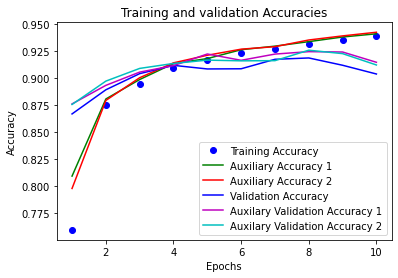

In [0]:
import matplotlib.pyplot as plt

history_dict = google_hist.history
print(history_dict)
acc = history_dict['main_accuracy']
ax_acc = history_dict['aux1_accuracy']
ax2_acc = history_dict['aux2_accuracy']

val_acc = history_dict['val_main_accuracy']
val_ax_acc = history_dict['val_aux1_accuracy']
val_ax2_acc = history_dict['val_aux2_accuracy']

ax_loss = history_dict['aux1_loss']
ax2_loss = history_dict['aux2_loss']
loss = history_dict['main_loss']

val_loss = history_dict['val_main_loss']
val_ax_loss = history_dict['val_aux1_loss']
val_ax2_loss = history_dict['val_aux2_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, ax_acc, 'g', label='Auxiliary Accuracy 1')
plt.plot(epochs, ax2_acc, 'r', label='Auxiliary Accuracy 2')

plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.plot(epochs, val_ax_acc, 'm', label='Auxilary Validation Accuracy 1')
plt.plot(epochs, val_ax2_acc, 'c', label='Auxilary Validation Accuracy 2')
plt.title('Training and validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

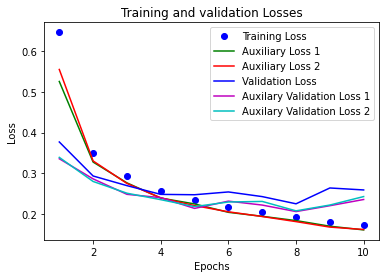

In [0]:
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, ax_loss, 'g', label='Auxiliary Loss 1')
plt.plot(epochs, ax2_loss, 'r', label='Auxiliary Loss 2')

plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.plot(epochs, val_ax_loss, 'm', label='Auxilary Validation Loss 1')
plt.plot(epochs, val_ax2_loss, 'c', label='Auxilary Validation Loss 2')
plt.title('Training and validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()